In [20]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker

In [ ]:
test_sample= "/home/compomics/git/MLMarker/data/test_sample.csv"
#get the first row from the 'test sampl'e
test_sample = pd.read_csv(test_sample, nrows=1)
test_sample.iloc[:,5:] = np.where(test_sample.iloc[:,5:] > 0, 1, 0)
test_sample
#remove_features = ['Q9UKX5','Q9UKX7','Q9UKY7','Q9UKZ1','Q9UL15','Q9UL25','Q9UL26','Q9UL42','Q9UL54','Q9ULC3','Q9ULC4','Q9ULC5','Q9ULD0','Q9ULD2','Q9ULE0','Q9ULE6','Q9ULH0','Q9ULH7','Q9ULJ3','Q9ULJ7','Q9ULJ8','Q9ULL0','Q9ULL5','Q9ULM3','Q9ULR0','Q9ULR3','Q9ULV0','Q9ULW0','Q9ULX3','Q9ULX6','Q9ULZ3','Q9UM07','Q9UM22','Q9UM47','Q9UMS0','Q9UMS4','Q9UMS6','Q9UMX0','Q9UMX1','Q9UMX3','Q9UMX5','Q9UMZ2','Q9UN37','Q9UN70','Q9UN86','Q9UNF0','Q9UNI6','Q9UNS2','Q9UNW1','Q9UNW9','Q9UNX3','Q9UNX4','Q9UNY4','Q9UNZ2','Q9UP83','Q9UPA5','Q9UPM8','Q9UPN7','Q9UPN9','Q9UPR3','Q9UPU5','Q9UPU7','Q9UPV7','Q9UPY3','Q9UPY6','Q9UPZ3','Q9UQ03','Q9UQ13','Q9UQ35','Q9UQ80','Q9UQE7','Q9UQR1','Q9Y217','Q9Y223','Q9Y224','Q9Y228','Q9Y230','Q9Y237','Q9Y244','Q9Y250','Q9Y259','Q9Y263','Q9Y265','Q9Y266','Q9Y277','Q9Y281','Q9Y294','Q9Y295','Q9Y2A7','Q9Y2C4','Q9Y2D0','Q9Y2D5','Q9Y2G2','Q9Y2H1','Q9Y2H6','Q9Y2I1','Q9Y2I7','Q9Y2J8','Q9Y2K3','Q9Y2L9','Q9Y2P4','Q9Y2P5','Q9Y2Q0','Q9Y2Q3','Q9Y2Q5','Q9Y2R0','Q9Y2R4','Q9Y2S6','Q9Y2S7','Q9Y2T2','Q9Y2T3','Q9Y2U5','Q9Y2U8','Q9Y2V2','Q9Y2V7','Q9Y2W2','Q9Y2X3','Q9Y2X9','Q9Y2Y8','Q9Y2Z0','Q9Y2Z4','Q9Y305','Q9Y316','Q9Y320','Q9Y333','Q9Y366','Q9Y376','Q9Y385','Q9Y394','Q9Y399','Q9Y3A2','Q9Y3A4','Q9Y3A6','Q9Y3B4','Q9Y3B7','Q9Y3B9','Q9Y3C4','Q9Y3C6','Q9Y3C8','Q9Y3D0','Q9Y3D2','Q9Y3D5','Q9Y3D6','Q9Y3D9','Q9Y3E1','Q9Y3E2','Q9Y3E7','Q9Y3F4','Q9Y3I0','Q9Y3I1','Q9Y3L3','Q9Y3P9','Q9Y3Q3','Q9Y3Q8','Q9Y3R5','Q9Y3T9','Q9Y3U8','Q9Y3Z3','Q9Y426','Q9Y446','Q9Y478','Q9Y490','Q9Y4B5','Q9Y4B6','Q9Y4C1','Q9Y4C2','Q9Y4C8','Q9Y4D1','Q9Y4D7','Q9Y4E6','Q9Y4E8','Q9Y4G6','Q9Y4H2','Q9Y4J8','Q9Y4K3','Q9Y4K4','Q9Y4P1','Q9Y4P8','Q9Y4W2','Q9Y4W6','Q9Y4X5','Q9Y4Y9','Q9Y512','Q9Y570','Q9Y572','Q9Y584','Q9Y5A9','Q9Y5B6','Q9Y5B9','Q9Y5J1','Q9Y5J6','Q9Y5J7','Q9Y5K6','Q9Y5L3','Q9Y5L4','Q9Y5M8','Q9Y5N5','Q9Y5P6','Q9Y5R8','Q9Y5S1','Q9Y5S2','Q9Y5S9','Q9Y5T5','Q9Y5U8','Q9Y5V3','Q9Y5X1','Q9Y5X2','Q9Y5X3','Q9Y5Y6','Q9Y5Y7','Q9Y5Z4','Q9Y5Z7','Q9Y608','Q9Y613','Q9Y617','Q9Y619','Q9Y623','Q9Y624','Q9Y625','Q9Y646','Q9Y657','Q9Y673','Q9Y676','Q9Y678','Q9Y679','Q9Y680','Q9Y692','Q9Y696','Q9Y697','Q9Y6A4','Q9Y6C2','Q9Y6C9','Q9Y6D5','Q9Y6D6','Q9Y6D9','Q9Y6G9','Q9Y6H1','Q9Y6I3','Q9Y6K5','Q9Y6M5','Q9Y6N5','Q9Y6N6','Q9Y6P5','Q9Y6Q1','Q9Y6Q9','Q9Y6R1','Q9Y6U3','Q9Y6V0','Q9Y6V7','Q9Y6W3','Q9Y6W5','Q9Y6X5','Q9Y6X8','Q9Y6X9','Q9Y6Y0','Q9Y6Y8']
#test_sample = test_sample.drop(columns=remove_features)
test = MLMarker("/home/compomics/git/MLMarker/models/binary_TP_full_92%_10exp_2024.joblib", "/home/compomics/git/MLMarker/models/binary_used_features_tissue_predictor_RF_full_opt_nocart_2024.txt", test_sample)

In [22]:
test_sample

,index,assay_id,cell_type,tissue_name,disease_status,fluid,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,...,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8
0,3808,6894,Small intestine,Small intestine,Diseased,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


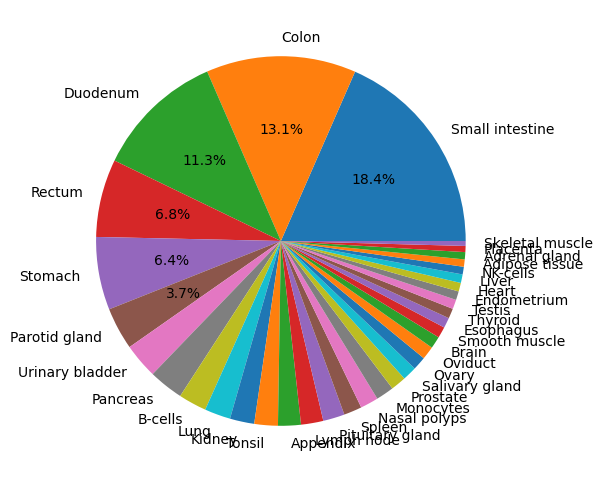

In [23]:
MLMarker.pie_chart_predictions(test)

In [24]:
MLMarker.predict_top_tissues(test)

[('Small intestine', 0.1843),
 ('Colon', 0.131),
 ('Duodenum', 0.113),
 ('Rectum', 0.0681),
 ('Stomach', 0.0638)]

The base value is 0.02857142857142838
Small intestine


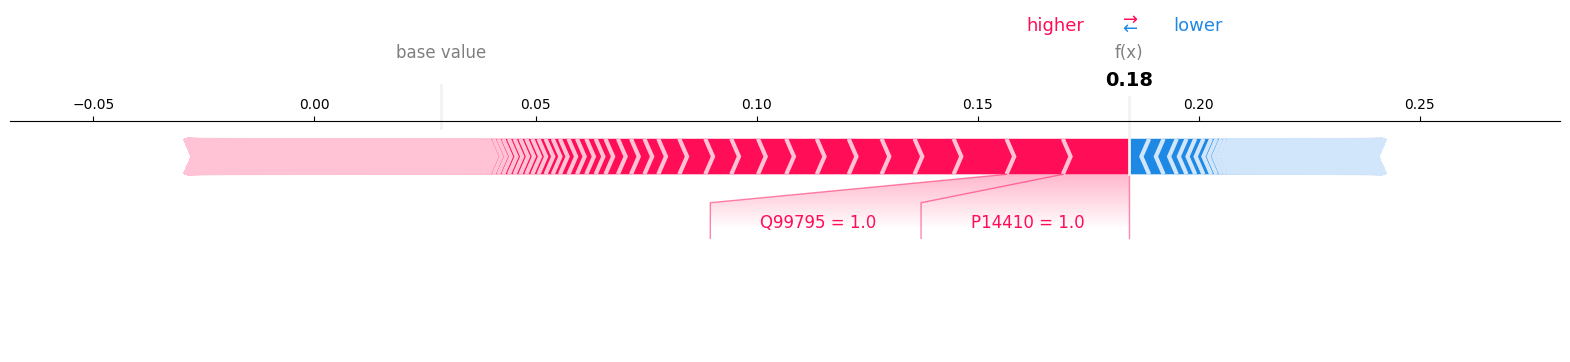

None

Colon


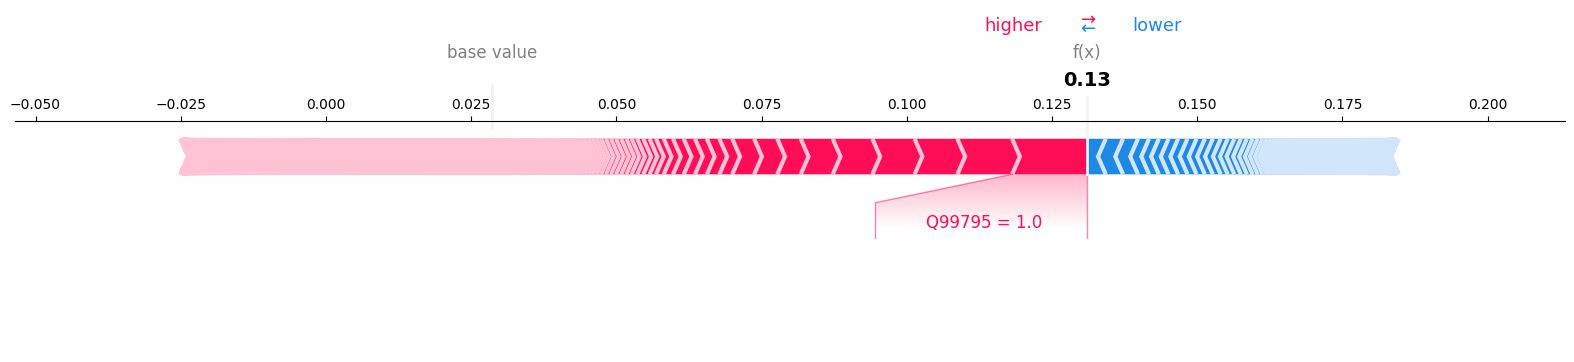

None

Duodenum


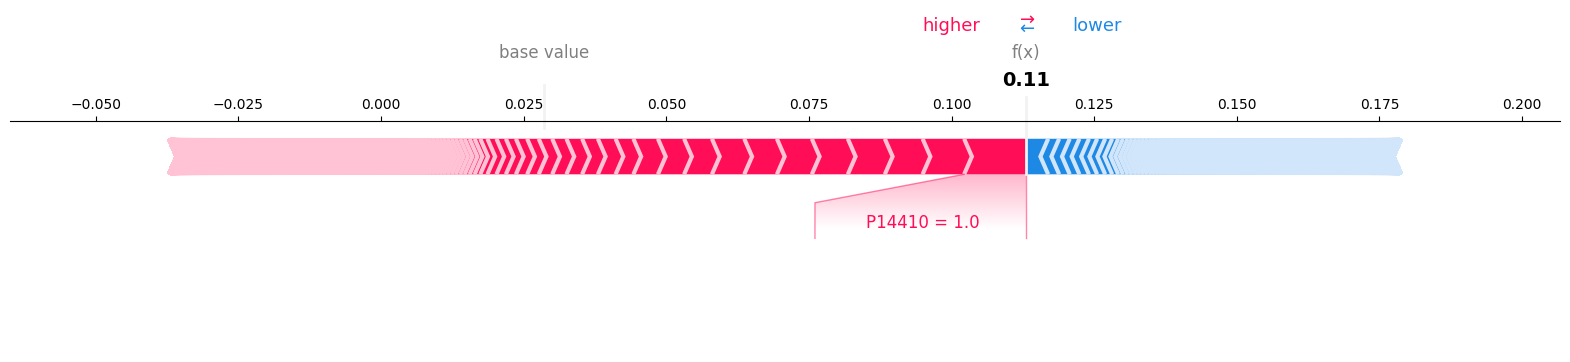

None

In [25]:
MLMarker.visualize_shap_force_plot(test, n_preds=3)